In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy scipy pandas matplotlib numpy_ringbuffer sklearn

import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from strategy import Strategy

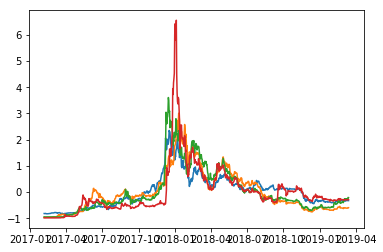

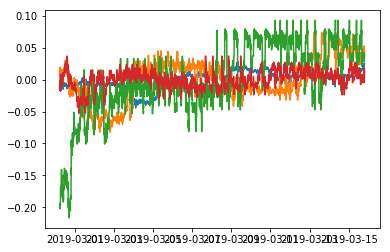

In [2]:
currencies = ['usd', 'btc', 'eth', 'ltc', 'xrp', 'eos']
pairs = [c + '_usd' for c in currencies if c != 'usd']
volume_keys = [c + '_tx_volume' for c in currencies if c != 'usd']

def prep_data(file):
    data = pickle.load(open(file, 'rb'))
    dates = [x['date'] for x in data]
    prices = [{k:v for k,v in x.items() if k in pairs} for x in data]
    volumes = [{(k.partition('_')[0] + '_usd'):v for k,v in x.items() if k in volume_keys} for x in data]
    return {
        'prices': pd.DataFrame(prices, index = dates),
        'volumes': pd.DataFrame(volumes, index = dates)
    }

def reduce_data(data, resampling):
    '''Averages prices, sums volumes'''
    prices = data['prices'].resample(resampling).first().fillna(method='ffill')
    volumes = data['volumes'].resample(resampling).sum().fillna(method='ffill')
    return { 'prices': prices, 'volumes': volumes }

def tail_data(data, n):
    '''get the last n points of the given data'''
    prices = data['prices'].tail(n)
    volumes = data['volumes'].tail(n)
    return { 'prices': prices, 'volumes': volumes }

def viz_data(data):
    '''Only plots prices for now'''
    plt.plot(data['prices'] / data['prices'].mean() - 1)
    plt.show()

def find_gaps(data, freq):
    idx_ref = pd.date_range(start=data.index[0], end=data.index[-1],freq=freq)
    gaps = idx_ref[~idx_ref.isin(data.index)]
    return gaps

data = prep_data('data/data.p')
viz_data(data)
data_min = reduce_data(prep_data('data/data-minute.p'), '1Min')
data_5min = reduce_data(data_min, '5Min')
data_15min = reduce_data(data_min, '15Min')
viz_data(data_min)

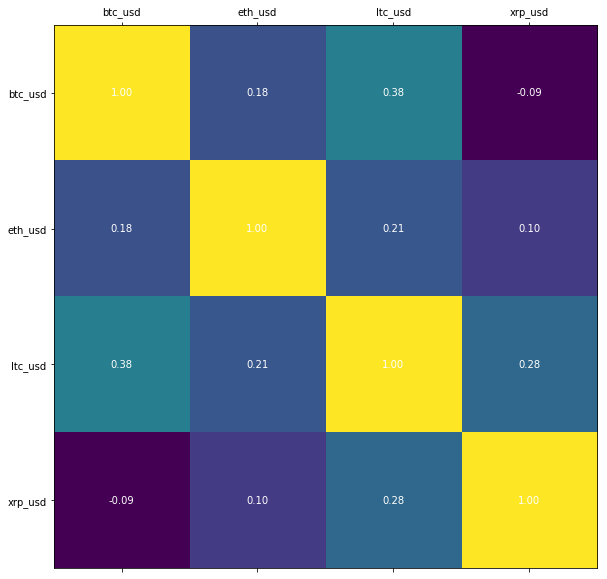

In [3]:
def plot_matrix(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(df)
    plt.xticks(range(len(df.columns)), df.columns);
    plt.yticks(range(len(df.index)), df.index);
    # Loop over data dimensions and create text annotations.
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            ax.text(j, i, '{:0.2f}'.format(df.iloc[i, j]), ha="center", va="center", color="w")

plot_matrix(data_15min['prices'].corr())

In [4]:
def cross_correlate_(x, y):
    return np.argmax(np.correlate(x, y, mode='full')) - len(x) + 1

def cross_correlate(df):
    '''Compute cross-correlation matrix for the given dataframe.'''
    ccs = pd.DataFrame(index=df.columns, columns=df.columns)
    for i in df.columns:
        for j in df.columns:
            if i == j:
                ccs.loc[i,j] = 0
                continue
            if np.isnan(ccs.loc[i,j]):
                ccs.loc[i,j] = cross_correlate_(df[i], df[j])
                ccs.loc[j,i] = -ccs.loc[i,j]
    return ccs

print(cross_correlate(pd.DataFrame([[1,2],[2,1],[1,2],[2,1],[1,2]])))
print(cross_correlate(pd.DataFrame([[1,1],[2,2],[3,3],[4,4],[5,5]])))
    
print(cross_correlate(data_min['prices']))

   0  1
0  0 -1
1  1  0
   0  1
0  0  0
1  0  0
         btc_usd  eth_usd  ltc_usd  xrp_usd
btc_usd        0        0        0        0
eth_usd        0        0        0        0
ltc_usd        0        0        0        0
xrp_usd        0        0        0        0


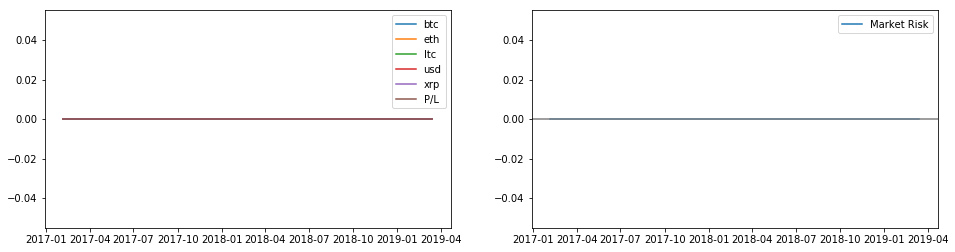

Return on maximum market risk: 0.0
Return on total market risk:   0.0
Return on total positions:     0.0
Sharpe ratio:                  0.0
Final P/L:                     0.0
Maximum absolute drawdown:     0
Maximum market risk:           0.0
Final balances:
usd    0.0
btc    0.0
eth    0.0
ltc    0.0
xrp    0.0
Name: 2019-03-14, dtype: float64


In [5]:
from strategy import HoldStrategy
from execution import run, analyze

analyze(run(HoldStrategy(), data))

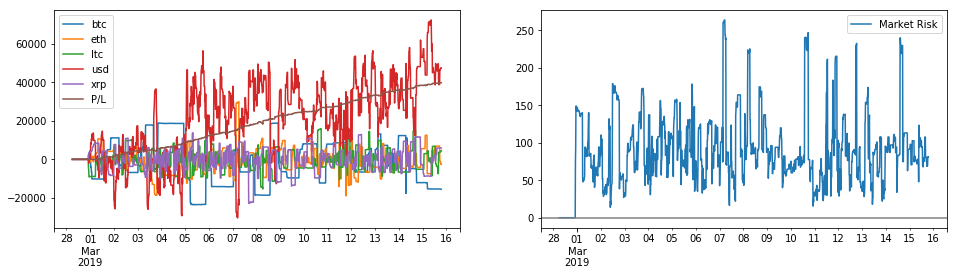

Return on maximum market risk: 150.63552506771106
Return on total market risk:   0.29745041973503367
Return on total positions:     0.0010784354697421965
Sharpe ratio:                  3.118164501879581
Final P/L:                     39737.32216184605
Maximum absolute drawdown:     1270.752200393592
Maximum market risk:           263.7978135899149
Final balances:
usd    47435.144424
btc       -3.942109
eth      -18.858505
ltc       77.071111
xrp    18782.320893
Name: 2019-03-15 19:00:00, dtype: float64


In [6]:
from strategy import KalmanFilterStrategy

analyze(run(KalmanFilterStrategy(correlation_window_size = 64, movement_half_life = 3), data_15min, fees=0.001))

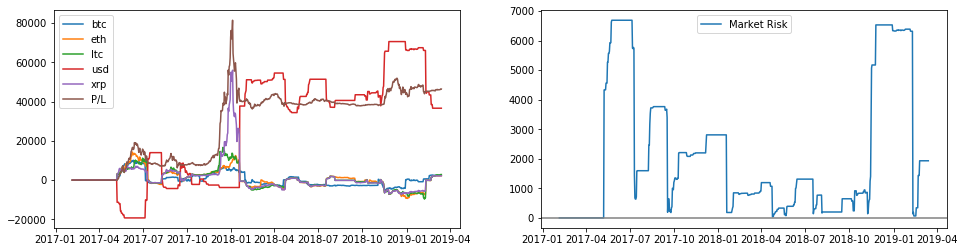

Return on maximum market risk: 6.9345926815511785
Return on total market risk:   0.028377258001255727
Return on total positions:     0.004763977801740213
Sharpe ratio:                  2.541108762519189
Final P/L:                     46366.40009613304
Maximum absolute drawdown:     45179.31911857941
Maximum market risk:           6686.247084055236
Final balances:
usd    36605.866735
btc        0.628086
eth       16.259162
ltc       46.387785
xrp     6883.319228
Name: 2019-03-14, dtype: float64


In [8]:
from strategy import CointegratorStrategy

analyze(run(CointegratorStrategy(cointegration_window_size = 64), tail_data(data, 1000)))

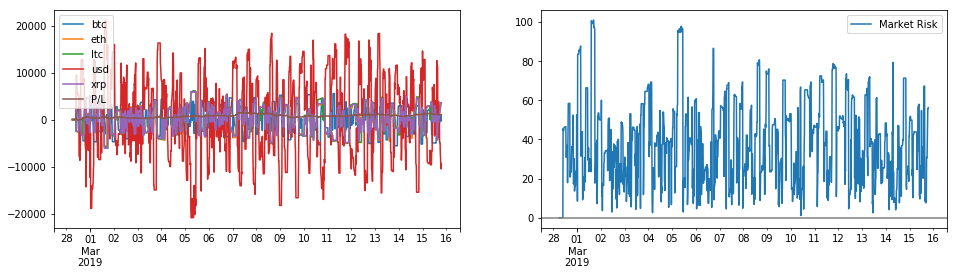

Return on maximum market risk: 10.20322057471837
Return on total market risk:   0.01747799693869786
Return on total positions:     7.139222074457507e-05
Sharpe ratio:                  3.1310573826421506
Final P/L:                     1030.1588145966648
Maximum absolute drawdown:     1091.3433672781491
Maximum market risk:           100.96408355104867
Final balances:
usd    -9393.683741
btc       -0.047551
eth       24.897137
ltc       60.474620
xrp    11379.427234
Name: 2019-03-15 19:00:00, dtype: float64


In [9]:
analyze(run(CointegratorStrategy(cointegration_window_size = 16), data_15min))

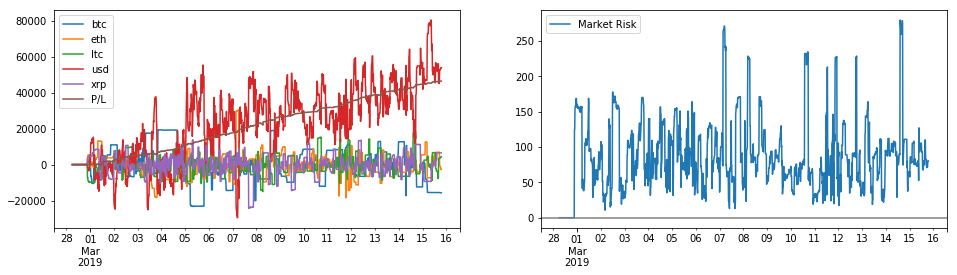

Return on maximum market risk: 166.0124683069042
Return on total market risk:   0.35437730982787075
Return on total positions:     0.0014383148201594887
Sharpe ratio:                  3.1504607545308922
Final P/L:                     46362.2376060453
Maximum absolute drawdown:     1230.0779061309913
Maximum market risk:           279.2696119686606
Final balances:
usd    53795.091529
btc       -3.982919
eth      -19.607194
ltc       74.879794
xrp    20889.395386
Name: 2019-03-15 19:00:00, dtype: float64


In [10]:
analyze(run(KalmanFilterStrategy(correlation_window_size = 60, movement_half_life = 3), data_15min))

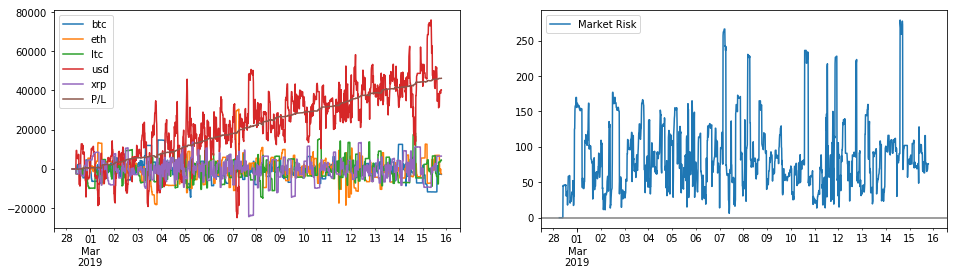

Return on maximum market risk: 165.49285796721858
Return on total market risk:   0.35415909715710714
Return on total positions:     0.0017426206358458149
Sharpe ratio:                  3.182882842443797
Final P/L:                     46196.640746170226
Maximum absolute drawdown:     1206.6356956407108
Maximum market risk:           279.14582727977586
Final balances:
usd    40335.229575
btc       -0.698660
eth      -17.710981
ltc       76.780116
xrp    20887.234969
Name: 2019-03-15 19:00:00, dtype: float64


In [12]:
from strategy import CombinedStrategy

analyze(run(CombinedStrategy([
    KalmanFilterStrategy(correlation_window_size = 60, movement_half_life = 3),
    CointegratorStrategy(cointegration_window_size = 16)
]), data_15min))

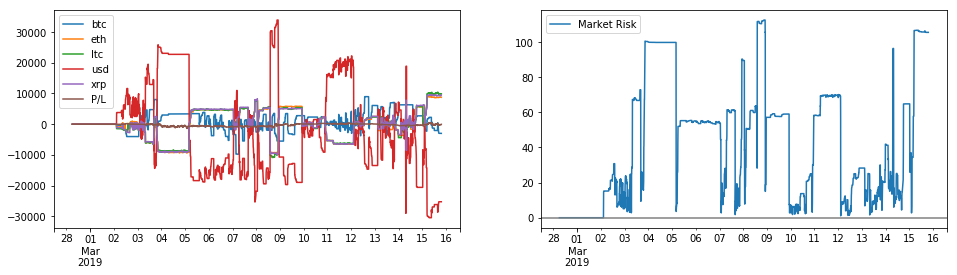

Return on maximum market risk: -0.26829442564955364
Return on total market risk:   -0.00015651075320151635
Return on total positions:     -4.8695648947698e-07
Sharpe ratio:                  -0.08481476848006604
Final P/L:                     -30.18593524109383
Maximum absolute drawdown:     1670.6717327511333
Maximum market risk:           112.51048234783636
Final balances:
usd   -25216.568273
btc       -0.757900
eth       62.879781
ltc      167.873553
xrp    29838.492840
Name: 2019-03-15 19:10:00, dtype: float64


In [13]:
analyze(run(CointegratorStrategy(cointegration_window_size = 512), data_5min))

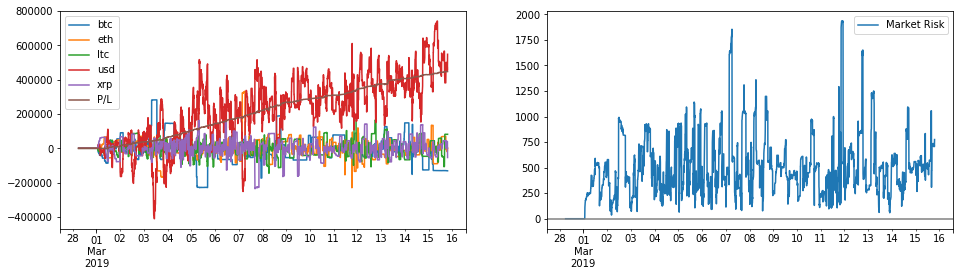

Return on maximum market risk: 230.98967336023273
Return on total market risk:   0.20197819829135163
Return on total positions:     0.000552029009675074
Sharpe ratio:                  3.0695870815904773
Final P/L:                     447003.214493697
Maximum absolute drawdown:     8432.093548826146
Maximum market risk:           1935.1653603863233
Final balances:
usd    547723.764352
btc       -33.328872
eth        16.787253
ltc      1385.011315
xrp   -168949.532120
Name: 2019-03-15 19:10:00, dtype: float64


In [14]:
analyze(run(KalmanFilterStrategy(correlation_window_size = 165, movement_half_life = 70), data_5min))

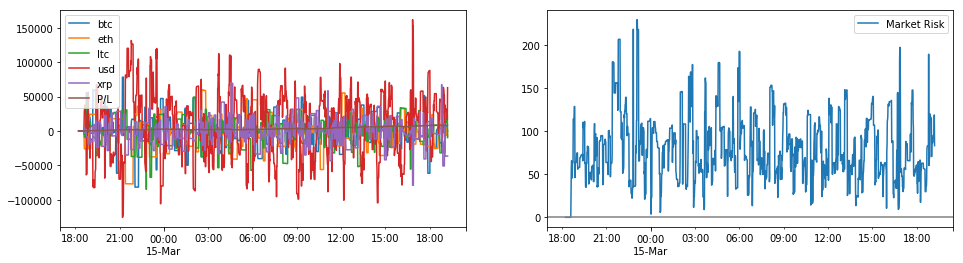

Return on maximum market risk: 37.681564283467104
Return on total market risk:   0.0714412364577578
Return on total positions:     8.3039832372363e-05
Sharpe ratio:                  3.877875421541012
Final P/L:                     8629.360018358908
Maximum absolute drawdown:     1307.1744809987158
Maximum market risk:           229.00747839020306
Final balances:
usd     62887.423450
btc         0.088292
eth       -60.249431
ltc      -166.049426
xrp   -115057.361429
Name: 2019-03-15 19:13:00, dtype: float64


In [15]:
analyze(run(CombinedStrategy([
    KalmanFilterStrategy(correlation_window_size = 16, movement_half_life = 8),
    CointegratorStrategy(cointegration_window_size = 64)
]), tail_data(data_min, 1500)))

In [ ]:
import random

def find_best_window_sizes(data, n):
    points = []
    best = None
    best_ror = 0
    for _ in range(n):
        movement_half_life = random.expovariate(1) * 30
#         window_ratio = random.uniform(1, 10)
#         window_size = max(3, int(movement_half_life * window_ratio))
#         movement_half_life = 2
        window_size = int(random.expovariate(1) * 60) + 60
#         window_size = int(random.expovariate(1) * 30) + 3
#         window_size = 4
#         window_size = 32
        print('Trying window_size: {0} and half_life: {1}'.format(window_size, movement_half_life))
        results = run(KalmanFilter(window_size, movement_half_life), data)
        ror = return_on_risk(results)
        print('  RoR: {0}'.format(ror))
        point = { 'window_size': window_size, 'half_life': movement_half_life, 'RoR': ror }
        points.append(point)
        if ror > best_ror:
            best = point
            best_ror = ror
    print('Best found:')
    print(best)
    pd.DataFrame(points).plot.scatter('window_size', 'half_life', c='RoR', colormap='jet')
    
find_best_window_sizes(tail_data(data_5min, 1000), 25)